In [1]:
import os
os.chdir("..")

In [2]:
from implicit_filter import CuPyFilter, convert_to_wavenumbers, make_tri
import math
import numpy as np

# Create mesh
---

### Define mesh parameters

In [3]:
# ============
# Mesh size:
# ============
Lx = 1000
Ly = Lx
# ===========
# Cell size and x,y vectors
# ===========
dxm = 1
dym = dxm
cyclic = 0  # 1 if mesh is cyclic
cyclic_length = 360  # in degrees; if not cyclic, take it larger than  zonal size
cyclic_length = cyclic_length * math.pi / 180  # DO NOT TOUCH
meshtype = 'r'  # coordinates can be in physical measure 'm' or in radians 'r'
cartesian = False
r_earth = 6400

### Create mesh

In [4]:
xx = np.arange(0, Lx + 1, dxm)
yy = np.arange(0, Ly + 1, dym)

nx = len(xx)
ny = len(yy)
# =============
# 2D regular array of points,
# their x and y coordinates.
# We will create triangles later
# =============

nodnum = np.arange(0, nx * ny)
xcoord = np.zeros((ny, nx))
ycoord = xcoord.copy()

for i in range(nx):
    ycoord[i, :] = yy

for i in range(ny):
    xcoord[:, i] = xx

### Create data

In [5]:
def make_data():
    tt = 50 * (np.random.random(xcoord.shape) - 0.5)
    ttf = np.fft.fft2(tt)
    # ============
    # Make spectrum red
    # ============
    espectrum = np.zeros((nx // 2 + 1))  # Place for Fourier spectrum
    kk = np.concatenate((np.arange(0, nx // 2 + 1), np.arange(-nx // 2 + 1, 0, 1)))  # Wavenumbers
    
    for mx in range(nx):
        for my in range(ny):
            ll = np.sqrt(kk[my] * kk[my] + kk[mx] * kk[mx])  # Absolute value
            if my == 0 and mx == 0:  # Remove area mean
                ttf[my, mx] = 0.0
            else:  # Adjust amplitudes
                 # 1.5 for -2 spectrum
                ttf[my, mx] /=  np.power(ll, 2.5)
            if ll + 1 <= nx / 2 + 1:
                espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])
    
    tt = np.real(np.fft.ifft2(ttf))  
    tt = np.reshape(tt, [nx * ny])
    return tt

In [6]:
%%time

import warnings
warnings.filterwarnings('ignore')

data = []
for i in range(10):
    data.append(make_data())

CPU times: user 1min 1s, sys: 132 ms, total: 1min 1s
Wall time: 1min 1s


### Reshape and create triangulation

In [7]:
nodnum = np.reshape(nodnum, [ny, nx]).T
xcoord = np.reshape(xcoord, [nx * ny])
ycoord = np.reshape(ycoord, [nx * ny])

xcoord /= r_earth
ycoord /= r_earth
alpha = math.pi/3 + math.pi/12
zg = np.sin(ycoord)
xg = np.cos(ycoord) * np.cos(xcoord)
yg = np.cos(ycoord) * np.sin(xcoord)
# Rotate by alpha
zn = zg * np.cos(alpha) + xg * np.sin(alpha)
xg = -zg * np.sin(alpha) + xg * np.cos(alpha)
# New coordinates in radians
ycoord = np.arcsin(zn)
xcoord = np.arctan2(yg,xg)
# New coordinates in degrees
ycoord = (180/math.pi) * np.arcsin(zn)
xcoord = (180/math.pi) * np.arctan2(yg,xg)

In [8]:
tri = make_tri(nodnum, nx, ny)
n2d = len(xcoord)  # The number of vertices(nodes)
e2d = len(tri[:, 1])

# Filtering
---

In [9]:
Kc = convert_to_wavenumbers(500, dxm)

### Prepare filter

In [10]:
jf = CuPyFilter()
jf.prepare(n2d, e2d, tri, xcoord, ycoord, meshtype, cartesian, cyclic_length, True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Compute velocity

In [11]:
ux = []
vy = []
for i in range(len(data)):
    ux.append(-100*np.sum(data[i][tri] * jf._dx, axis=1))
    vy.append(100*np.sum(data[i][tri] * jf._dy, axis=1))

Turn list of arrays into a 2D array

In [12]:
ux = np.stack(ux, axis=1)
vy = np.stack(vy, axis=1)

Comparing simple for-loop based implementation with optimized method

In [19]:
%%time
ttuv = []
ttvy = []
for i in range(len(ux.T)):
    print(i)
    tmp_u, tmp_v = jf.compute_velocity(1, Kc, ux[i], vy[i])
    ttuv.append(tmp_u)
    ttvy.append(tmp_v)

0
1
2
3
4
5
6
7
8
9
CPU times: user 21.1 s, sys: 303 ms, total: 21.4 s
Wall time: 19.7 s


In [20]:
%%time
ttuv, ttvy = jf.many_compute_velocity(1, Kc, ux, vy)

CPU times: user 21.8 s, sys: 4.06 s, total: 25.9 s
Wall time: 13.8 s


In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [15]:
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

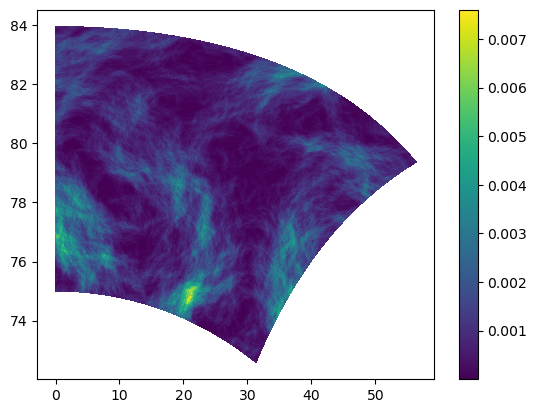

In [17]:
plt.tripcolor(triang, np.square(ux[:, -1]) + np.square(vy[:, -1]))
plt.colorbar()

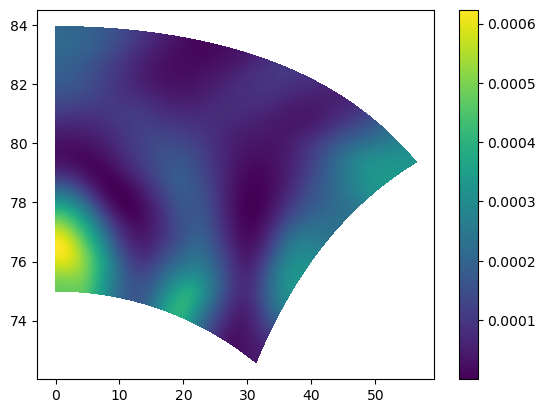

In [18]:
plt.tripcolor(triang, np.square(ttuv[-1]) + np.square(ttvy[-1]))
plt.colorbar()